# Musical Key Detection

This notebook loads an audio file and computes key-related features of that file, including an estimate of the track's key.

While not 100% sure, I think this assumes equal temperament. 

## Load the module containing the class definition

In [1]:
from music_production_and_performance.features.key_detection import KeyDetection

## Bach

[{'hop_length': 1024,
  'key_as_chromatic_index': 4,
  'key_as_pitch_class': 'E',
  'method': 'Short-Time Fourier Transform',
  'track_title': 'Bach',
  'track_to_analyze_filename': '/home/emily/Downloads/02 - Minuet from The '
                               'Anna Magdalena Bach Notebook, Anh. 114.mp3'},
 {'hop_length': 1024,
  'key_as_chromatic_index': 4,
  'key_as_pitch_class': 'E',
  'method': 'Constant-Q Transform',
  'track_title': 'Bach',
  'track_to_analyze_filename': '/home/emily/Downloads/02 - Minuet from The '
                               'Anna Magdalena Bach Notebook, Anh. 114.mp3'}]


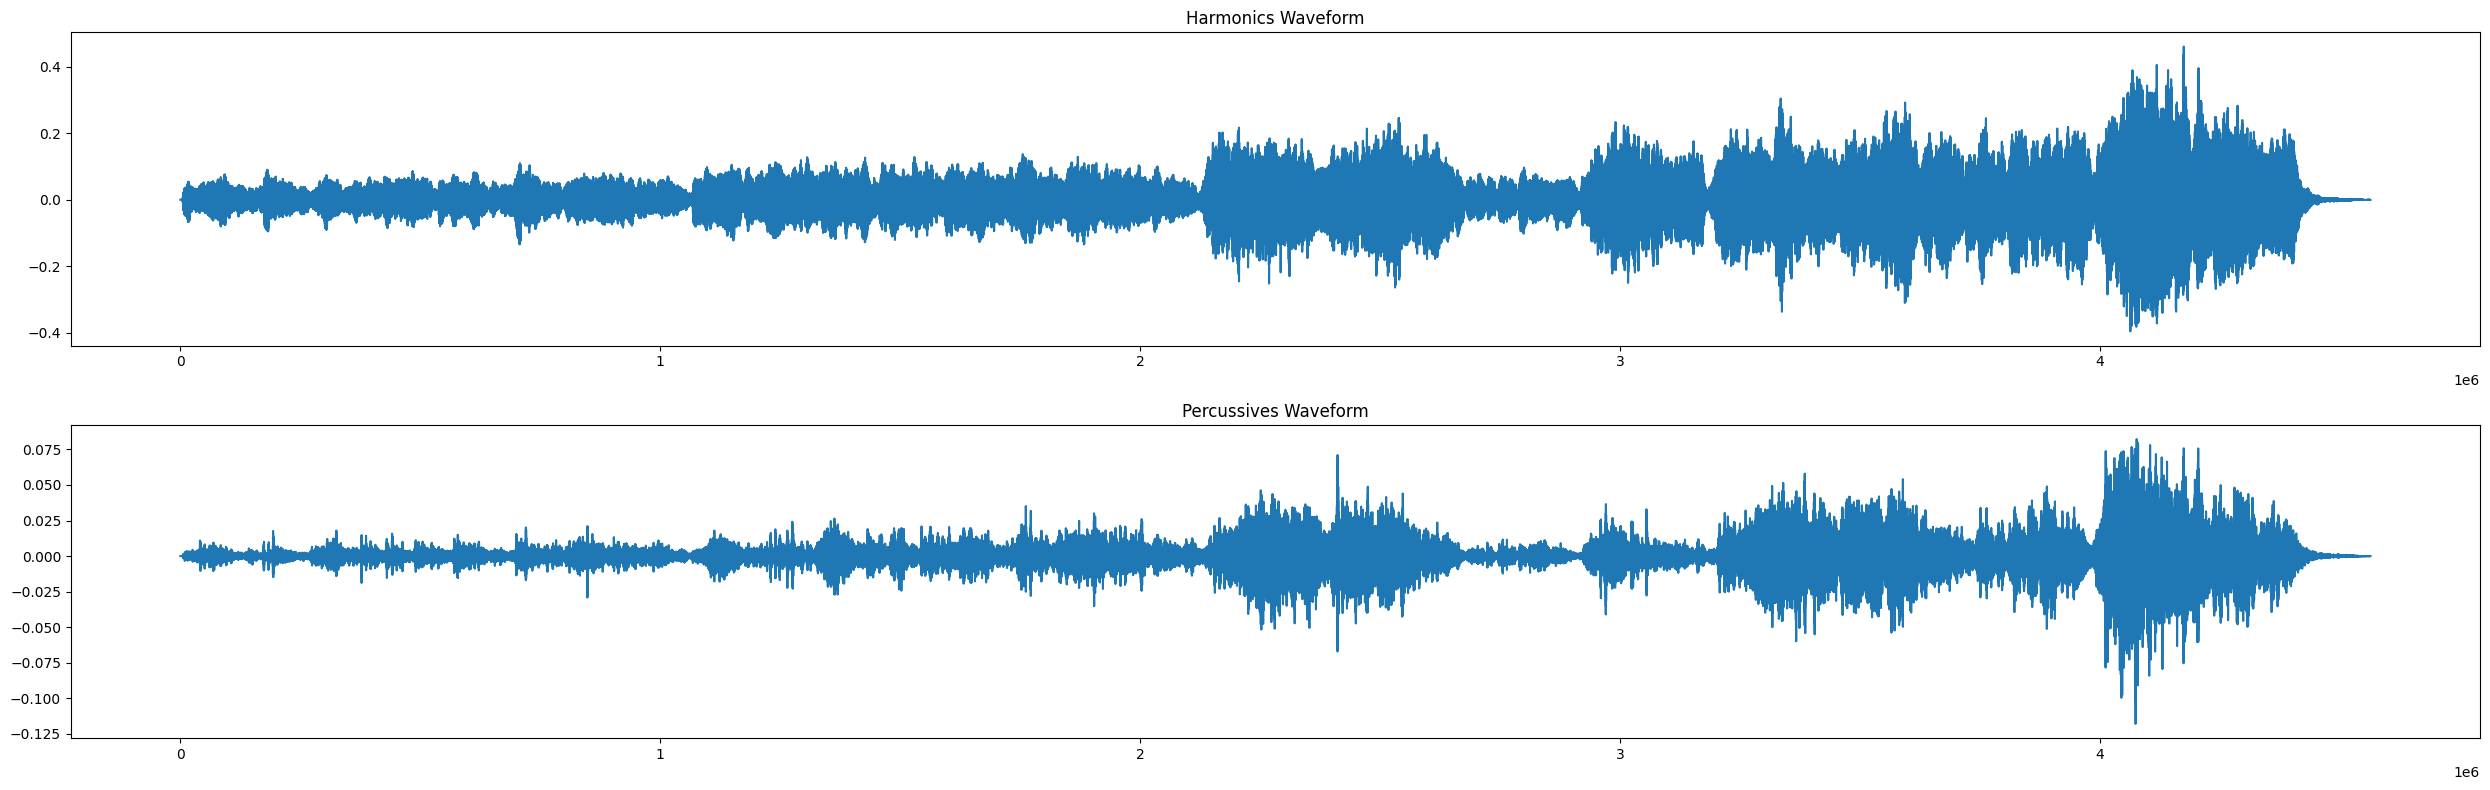

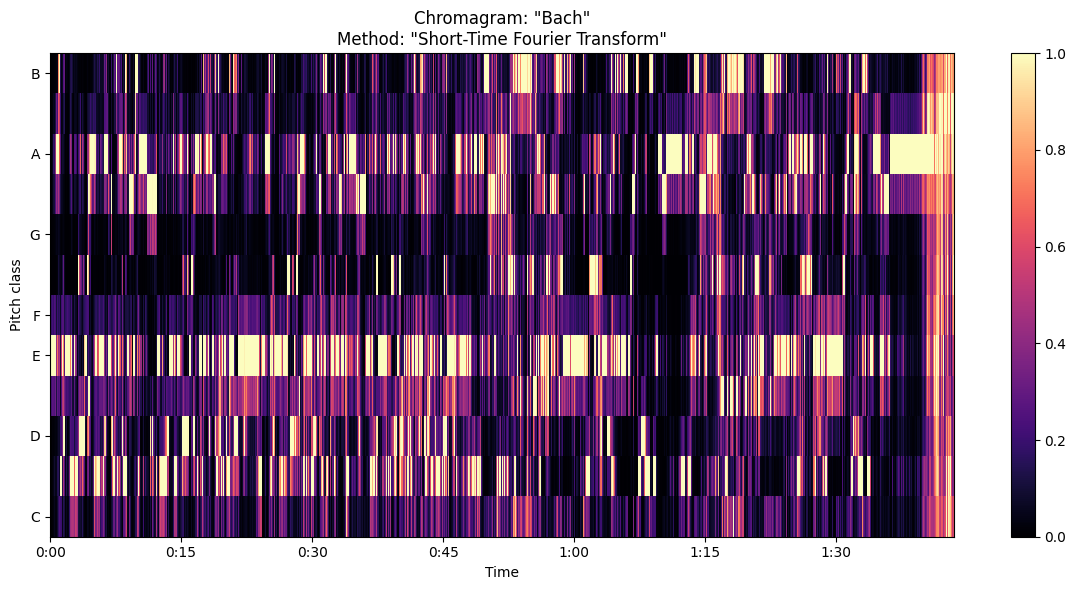

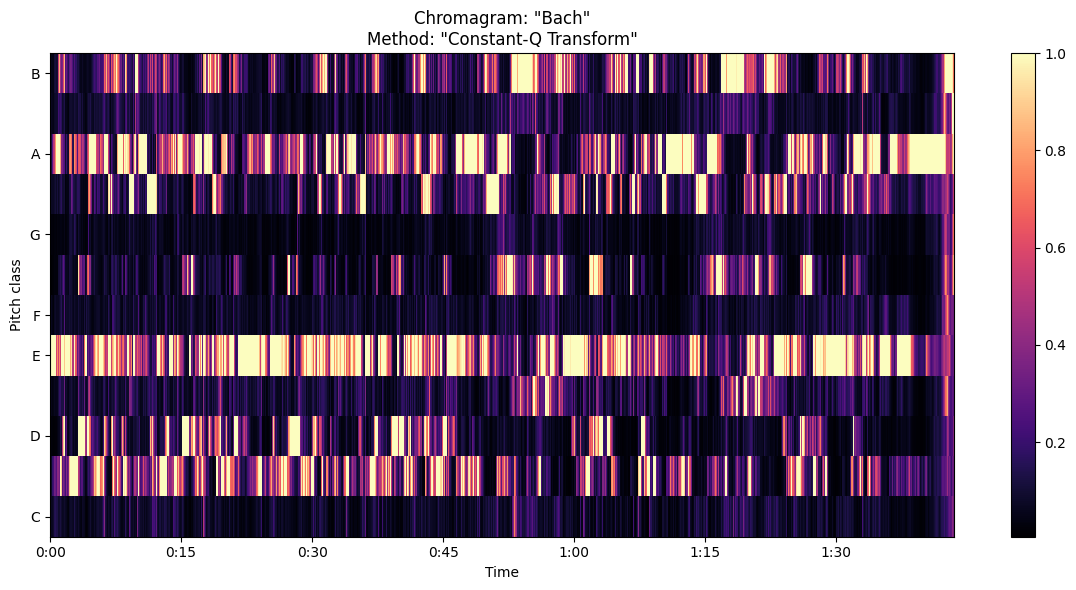

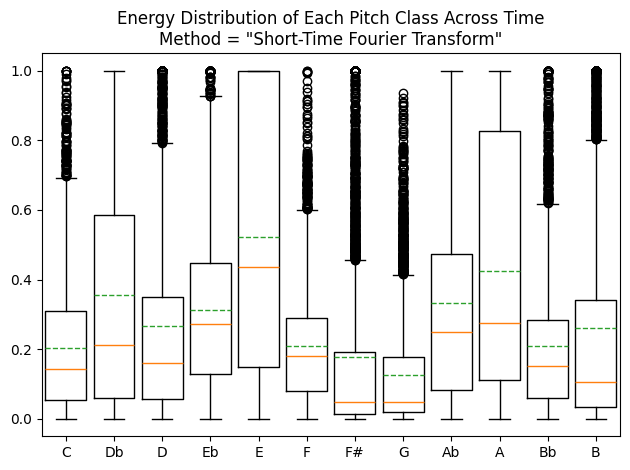

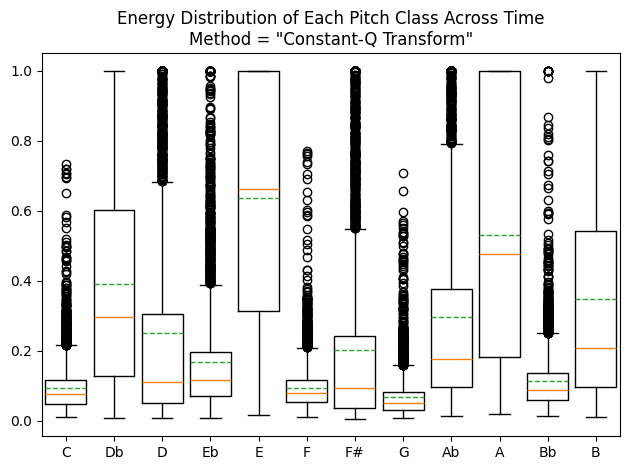

  track_title                          track_to_analyze_filename  \
0        Bach  /home/emily/Downloads/02 - Minuet from The Ann...   
1        Bach  /home/emily/Downloads/02 - Minuet from The Ann...   

                         method  hop_length  dissimilarity_index  \
0  Short-Time Fourier Transform        1024             0.155773   
1          Constant-Q Transform        1024             0.272845   

   chi2_goodness_of_fit_statistic  chi2_goodness_of_fit_p_value  \
0                     1444.877588                 2.496182e-303   
1                     4295.643536                  0.000000e+00   

   chi2_goodness_of_fit_cohens_w  kurtosis   entropy  
0                      10.972988 -0.206856  2.415076  
1                      18.920103 -0.490005  2.277656  


In [2]:
track_to_analyze = '/home/emily/Downloads/02 - Minuet from The Anna Magdalena Bach Notebook, Anh. 114.mp3'
track_name = 'Bach'
t_bach = KeyDetection(track_to_analyze, track_name)
t_bach.fit()
t_bach.summary_full()

In [3]:
t_bach.df

,track_title,track_to_analyze_filename,method,hop_length,key_as_chromatic_index,key_as_pitch_class,dissimilarity_index,chi2_goodness_of_fit_statistic,chi2_goodness_of_fit_p_value,chi2_goodness_of_fit_cohens_w,kurtosis,entropy
0,Bach,/home/emily/Downloads/02 - Minuet from The Ann...,Short-Time Fourier Transform,1024,4,E,0.155773,1444.877588,2.496182e-303,10.972988,-0.206856,2.415076
1,Bach,/home/emily/Downloads/02 - Minuet from The Ann...,Constant-Q Transform,1024,4,E,0.272845,4295.643536,0.000000e+00,18.920103,-0.490005,2.277656


## Stravinsky

[{'hop_length': 1024,
  'key_as_chromatic_index': 5,
  'key_as_pitch_class': 'F',
  'method': 'Short-Time Fourier Transform',
  'track_title': 'Stravinsky',
  'track_to_analyze_filename': '/home/emily/Downloads/04 - The Rite of Spring '
                               '(Scenes of Pagan Russia in Two Parts)_ Part '
                               'One - Spring Rounds (1921 Version).mp3'},
 {'hop_length': 1024,
  'key_as_chromatic_index': 3,
  'key_as_pitch_class': 'Eb',
  'method': 'Constant-Q Transform',
  'track_title': 'Stravinsky',
  'track_to_analyze_filename': '/home/emily/Downloads/04 - The Rite of Spring '
                               '(Scenes of Pagan Russia in Two Parts)_ Part '
                               'One - Spring Rounds (1921 Version).mp3'}]


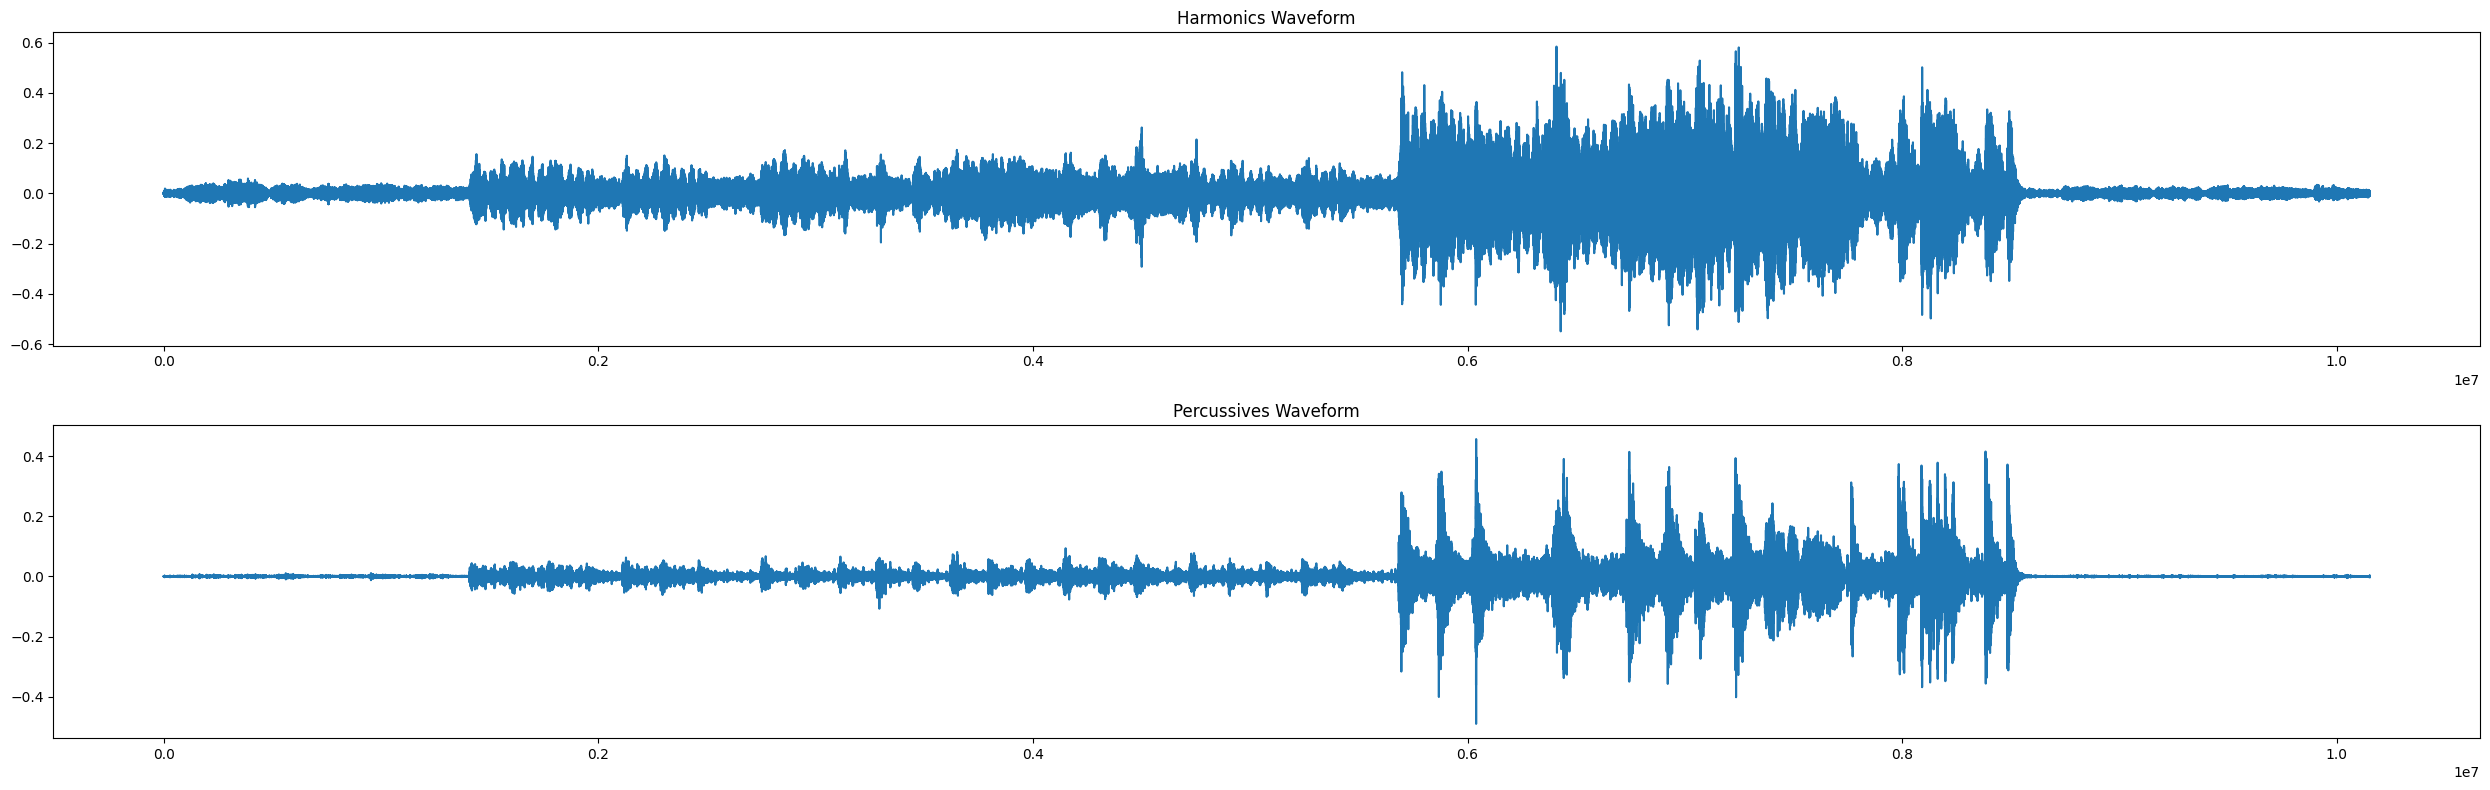

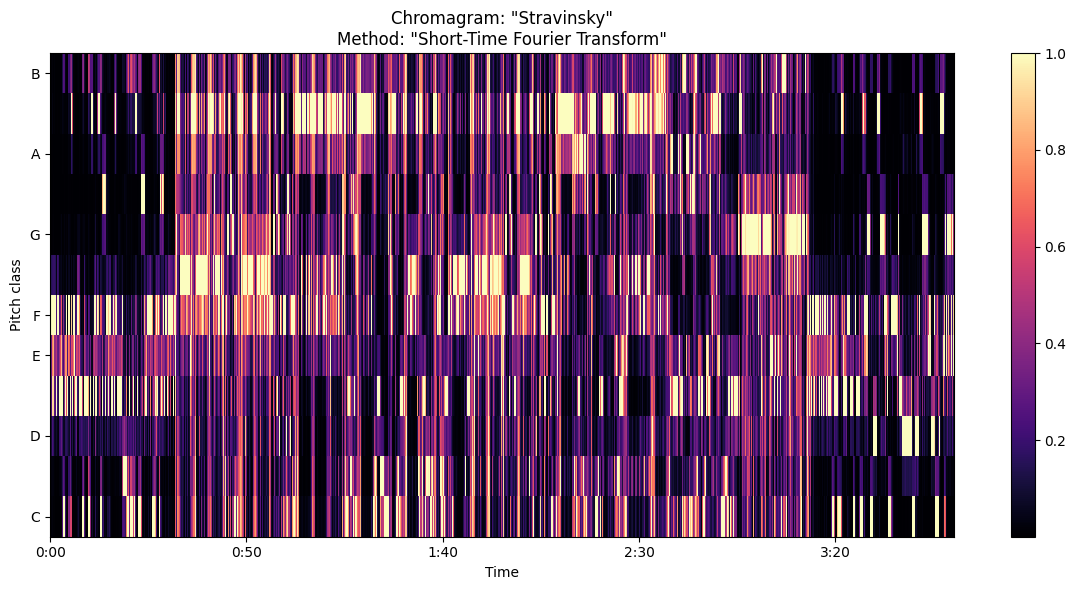

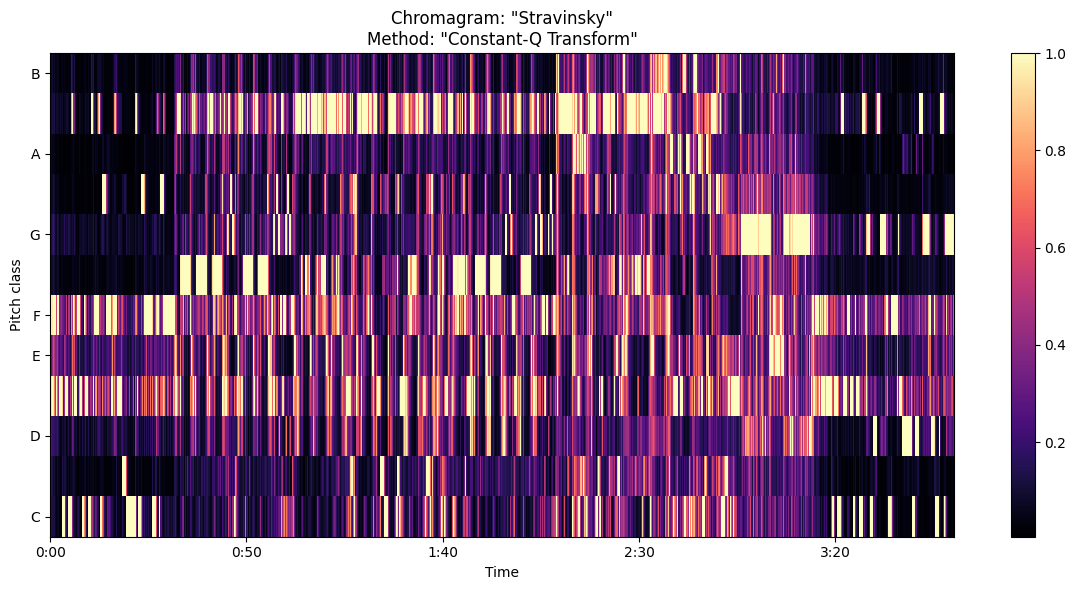

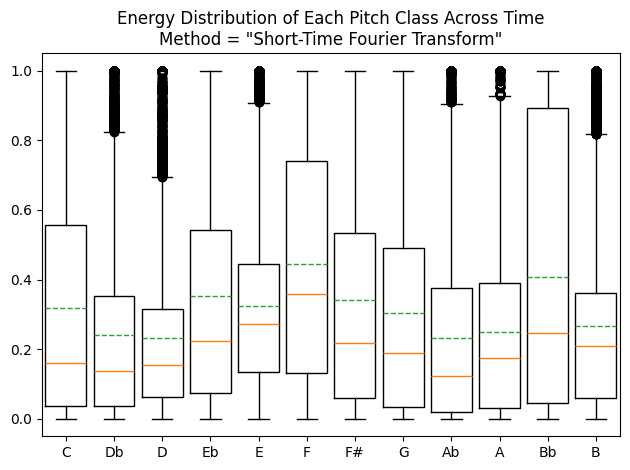

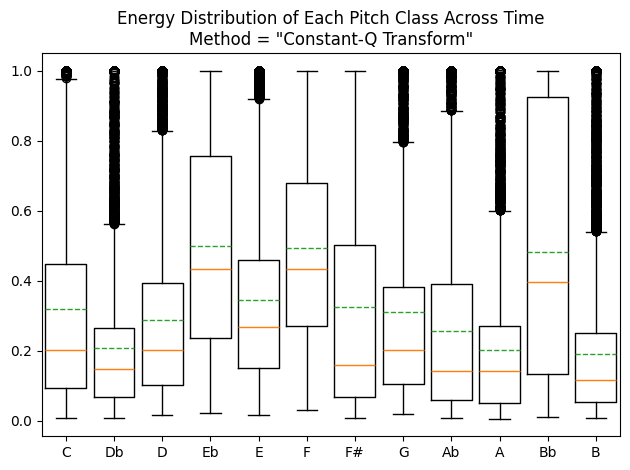

  track_title                          track_to_analyze_filename  \
0  Stravinsky  /home/emily/Downloads/04 - The Rite of Spring ...   
1  Stravinsky  /home/emily/Downloads/04 - The Rite of Spring ...   

                         method  hop_length  dissimilarity_index  \
0  Short-Time Fourier Transform        1024             0.088677   
1          Constant-Q Transform        1024             0.130234   

   chi2_goodness_of_fit_statistic  chi2_goodness_of_fit_p_value  \
0                      457.716800                  3.279744e-91   
1                     1063.567543                 3.979946e-221   

   chi2_goodness_of_fit_cohens_w  kurtosis   entropy  
0                       6.176007 -0.703946  2.462606  
1                       9.414384 -1.048805  2.432782  


In [4]:
track_to_analyze = '/home/emily/Downloads/04 - The Rite of Spring (Scenes of Pagan Russia in Two Parts)_ Part One - Spring Rounds (1921 Version).mp3'
track_name = 'Stravinsky'
t_strv = KeyDetection(track_to_analyze, track_name)
t_strv.fit()
t_strv.summary_full()

In [5]:
t_strv.df

,track_title,track_to_analyze_filename,method,hop_length,key_as_chromatic_index,key_as_pitch_class,dissimilarity_index,chi2_goodness_of_fit_statistic,chi2_goodness_of_fit_p_value,chi2_goodness_of_fit_cohens_w,kurtosis,entropy
0,Stravinsky,/home/emily/Downloads/04 - The Rite of Spring ...,Short-Time Fourier Transform,1024,5,F,0.088677,457.716800,3.279744e-91,6.176007,-0.703946,2.462606
1,Stravinsky,/home/emily/Downloads/04 - The Rite of Spring ...,Constant-Q Transform,1024,3,Eb,0.130234,1063.567543,3.979946e-221,9.414384,-1.048805,2.432782


## Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix)

[{'hop_length': 1024,
  'key_as_chromatic_index': 0,
  'key_as_pitch_class': 'C',
  'method': 'Short-Time Fourier Transform',
  'track_title': 'Kwiky Bridge (Instant Satisfaction Mix)',
  'track_to_analyze_filename': '/home/emily/Downloads/Lady Napalm - Kwiky '
                               'Bridge (Instant Satisfaction Mix).mp3'},
 {'hop_length': 1024,
  'key_as_chromatic_index': 0,
  'key_as_pitch_class': 'C',
  'method': 'Constant-Q Transform',
  'track_title': 'Kwiky Bridge (Instant Satisfaction Mix)',
  'track_to_analyze_filename': '/home/emily/Downloads/Lady Napalm - Kwiky '
                               'Bridge (Instant Satisfaction Mix).mp3'}]


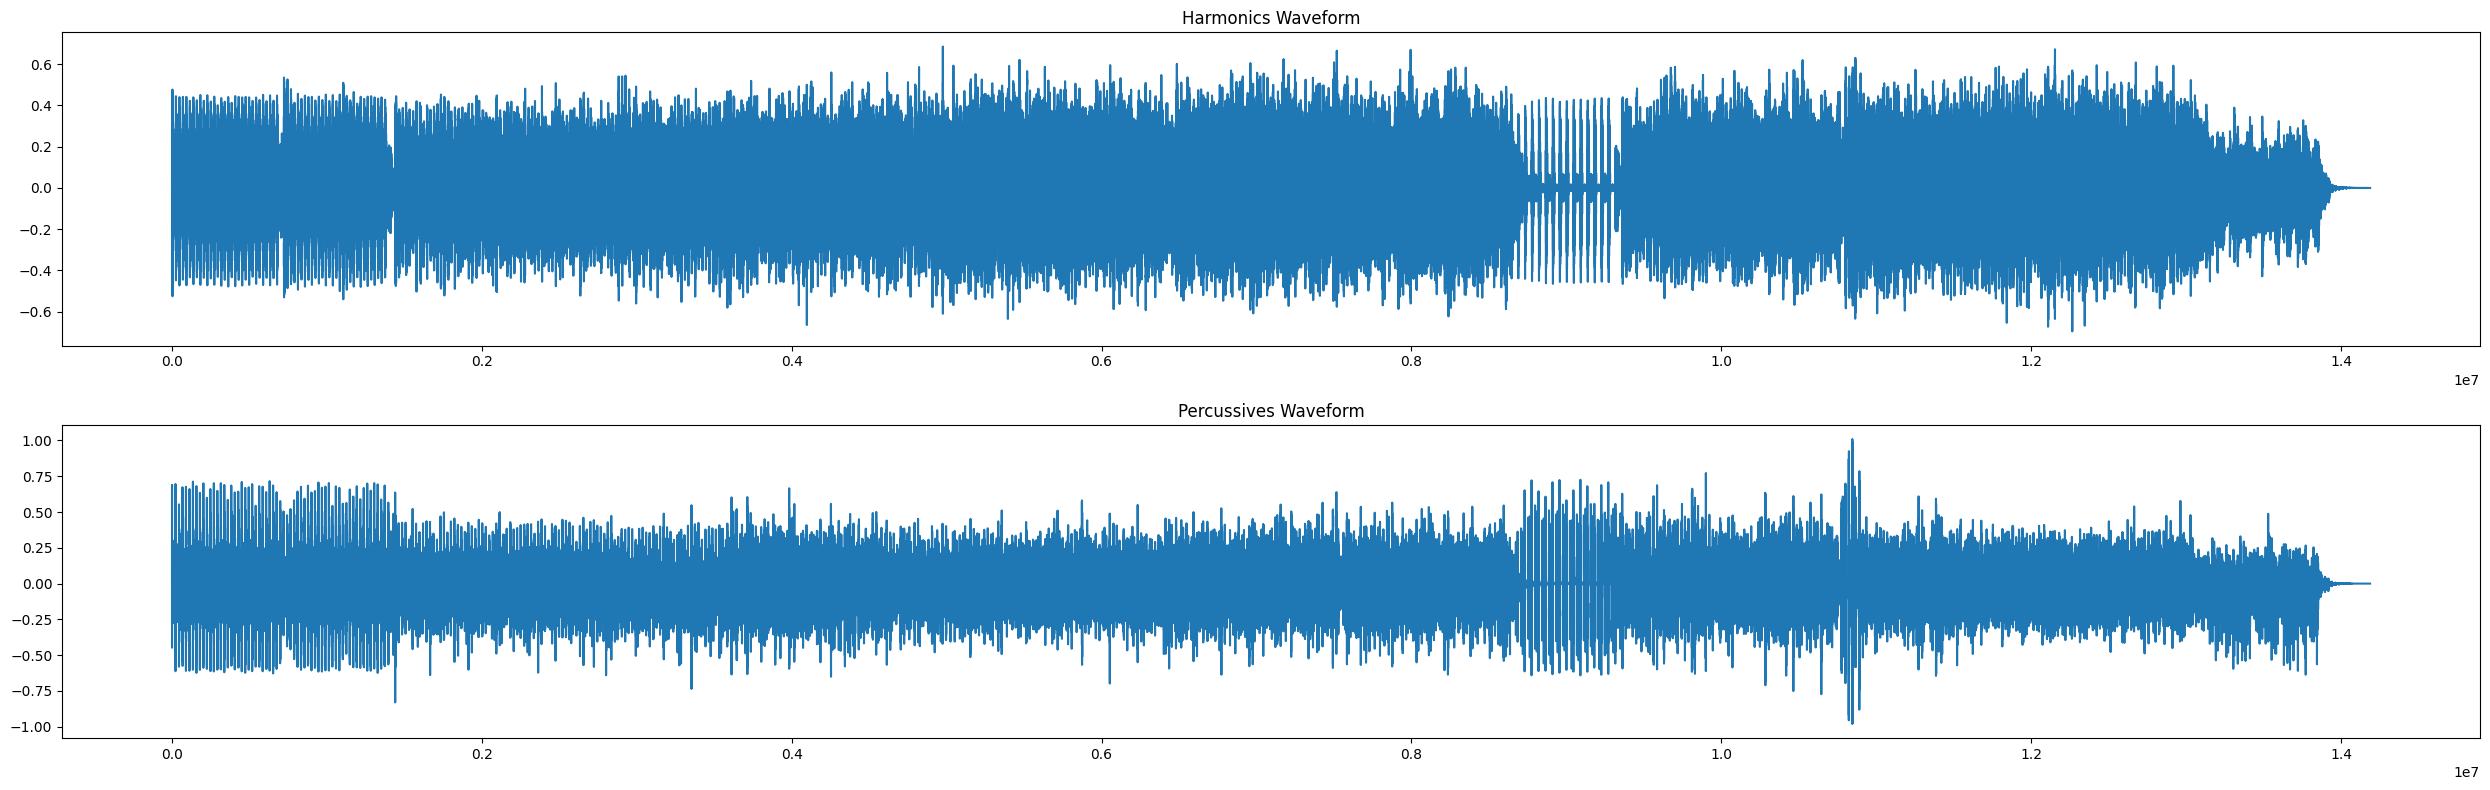

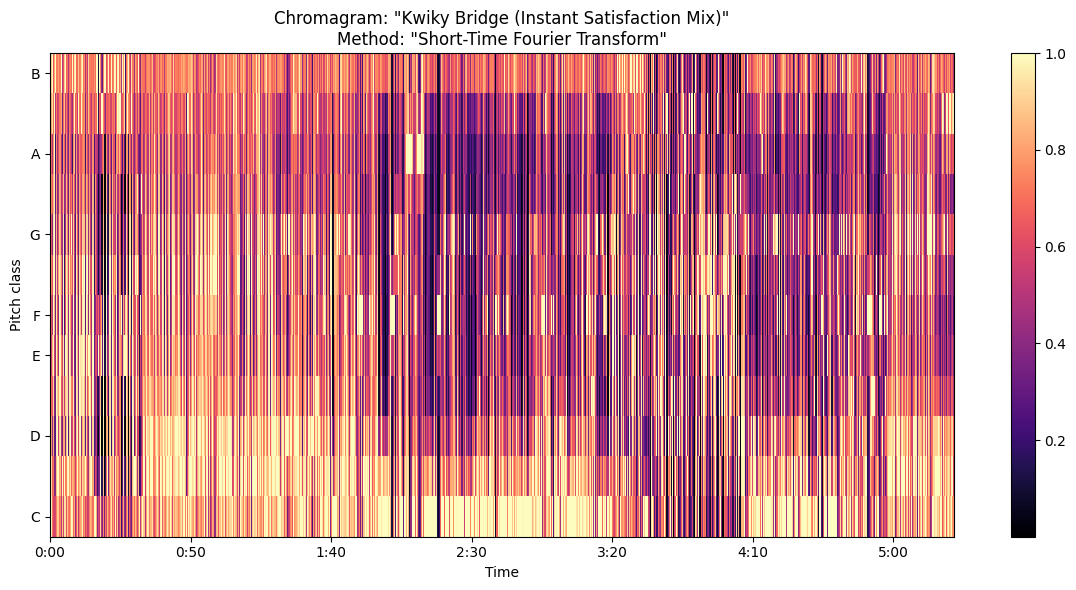

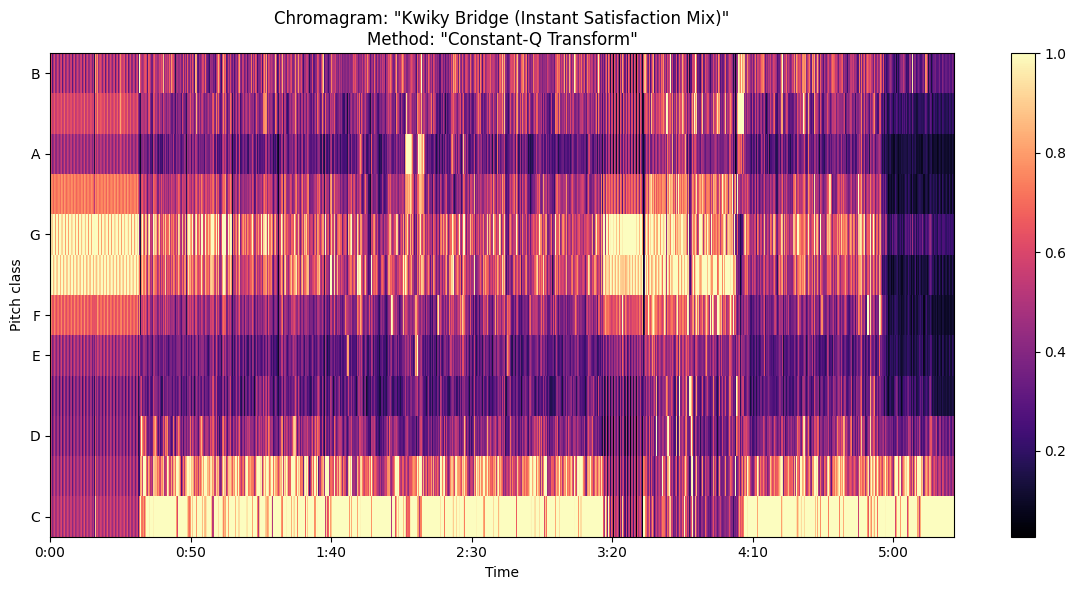

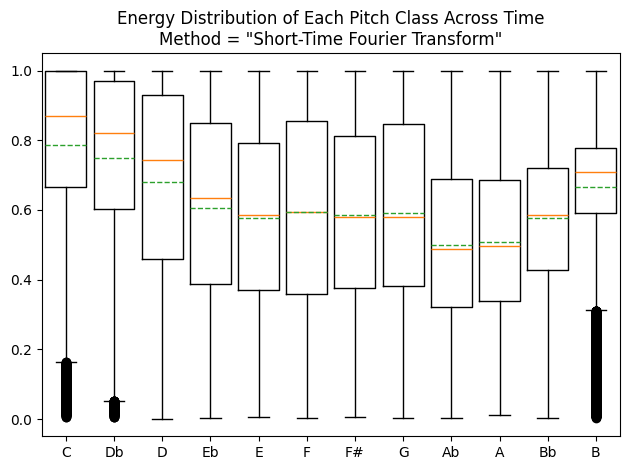

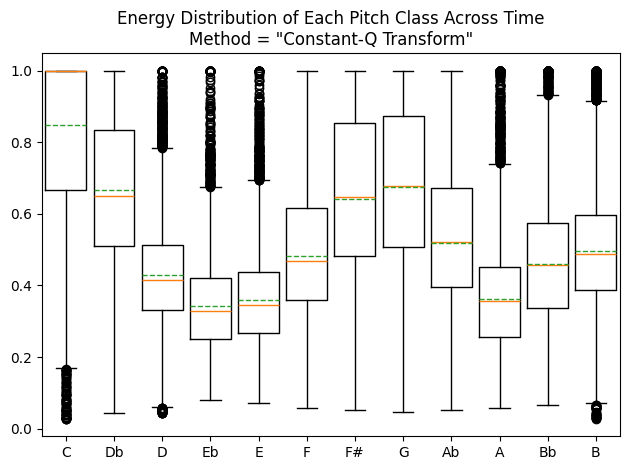

                               track_title  \
0  Kwiky Bridge (Instant Satisfaction Mix)   
1  Kwiky Bridge (Instant Satisfaction Mix)   

                           track_to_analyze_filename  \
0  /home/emily/Downloads/Lady Napalm - Kwiky Brid...   
1  /home/emily/Downloads/Lady Napalm - Kwiky Brid...   

                         method  hop_length  dissimilarity_index  \
0  Short-Time Fourier Transform        1024             0.054875   
1          Constant-Q Transform        1024             0.117061   

   chi2_goodness_of_fit_statistic  chi2_goodness_of_fit_p_value  \
0                      181.146985                  5.942297e-33   
1                      799.256000                 2.736940e-164   

   chi2_goodness_of_fit_cohens_w  kurtosis   entropy  
0                       3.885303 -0.492144  2.476019  
1                       8.161168 -0.451667  2.446330  


In [6]:
track_to_analyze = '/home/emily/Downloads/Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix).mp3'
track_name = 'Kwiky Bridge (Instant Satisfaction Mix)'
t_kb = KeyDetection(track_to_analyze, track_name)
t_kb.fit()
t_kb.summary_full()

In [7]:
t_kb.df

,track_title,track_to_analyze_filename,method,hop_length,key_as_chromatic_index,key_as_pitch_class,dissimilarity_index,chi2_goodness_of_fit_statistic,chi2_goodness_of_fit_p_value,chi2_goodness_of_fit_cohens_w,kurtosis,entropy
0,Kwiky Bridge (Instant Satisfaction Mix),/home/emily/Downloads/Lady Napalm - Kwiky Brid...,Short-Time Fourier Transform,1024,0,C,0.054875,181.146985,5.942297e-33,3.885303,-0.492144,2.476019
1,Kwiky Bridge (Instant Satisfaction Mix),/home/emily/Downloads/Lady Napalm - Kwiky Brid...,Constant-Q Transform,1024,0,C,0.117061,799.256000,2.736940e-164,8.161168,-0.451667,2.446330


## Lady Napalm - Voice in the Distance

[{'hop_length': 1024,
  'key_as_chromatic_index': 6,
  'key_as_pitch_class': 'F#',
  'method': 'Short-Time Fourier Transform',
  'track_title': 'Voice in the Distance',
  'track_to_analyze_filename': '/home/emily/Downloads/Lady Napalm - Voice in '
                               'the Distance.mp3'},
 {'hop_length': 1024,
  'key_as_chromatic_index': 6,
  'key_as_pitch_class': 'F#',
  'method': 'Constant-Q Transform',
  'track_title': 'Voice in the Distance',
  'track_to_analyze_filename': '/home/emily/Downloads/Lady Napalm - Voice in '
                               'the Distance.mp3'}]


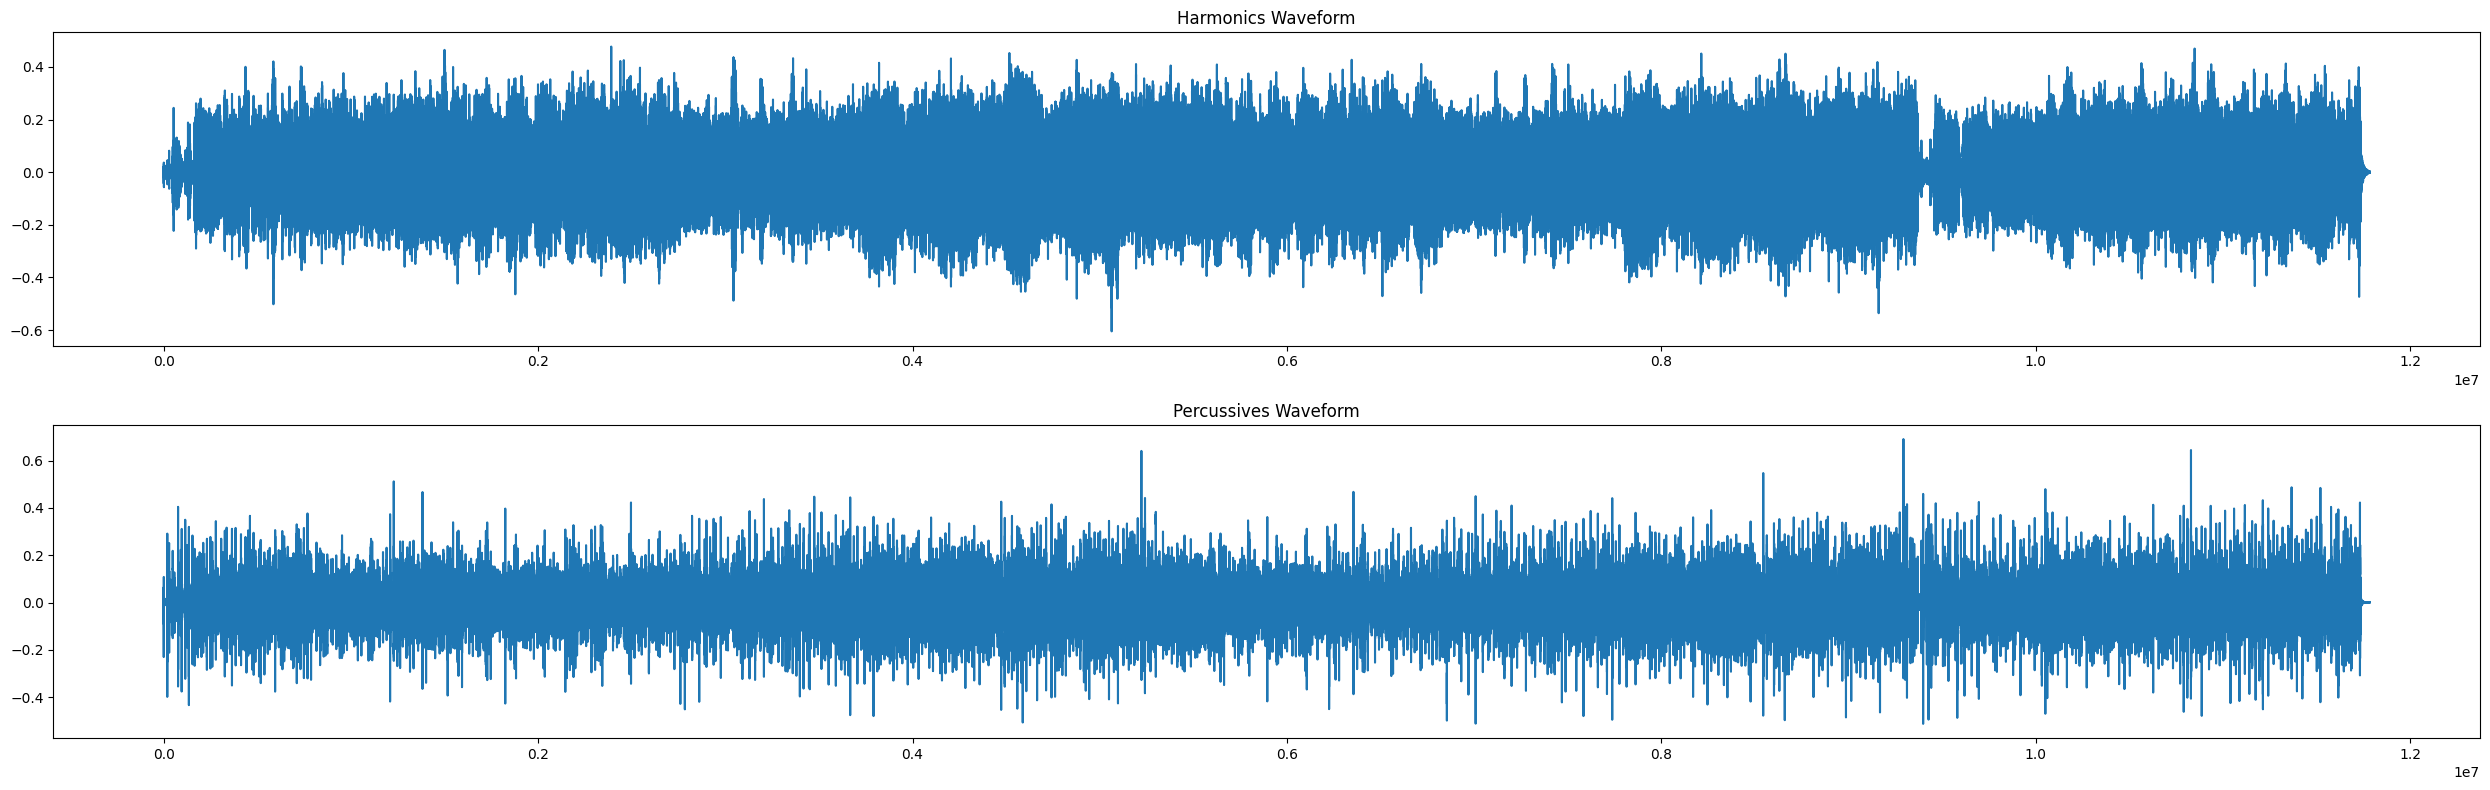

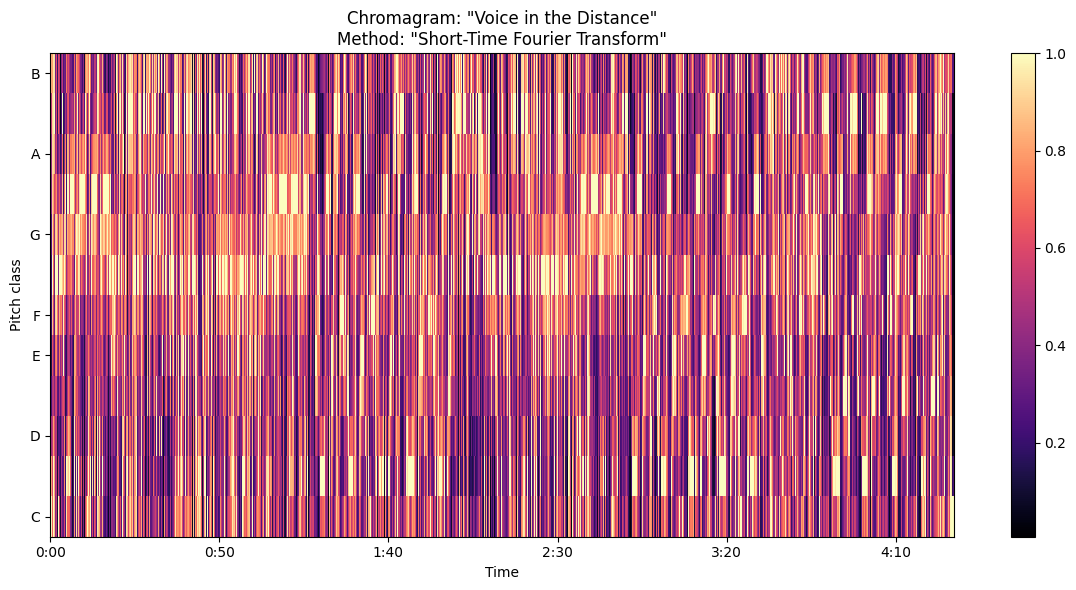

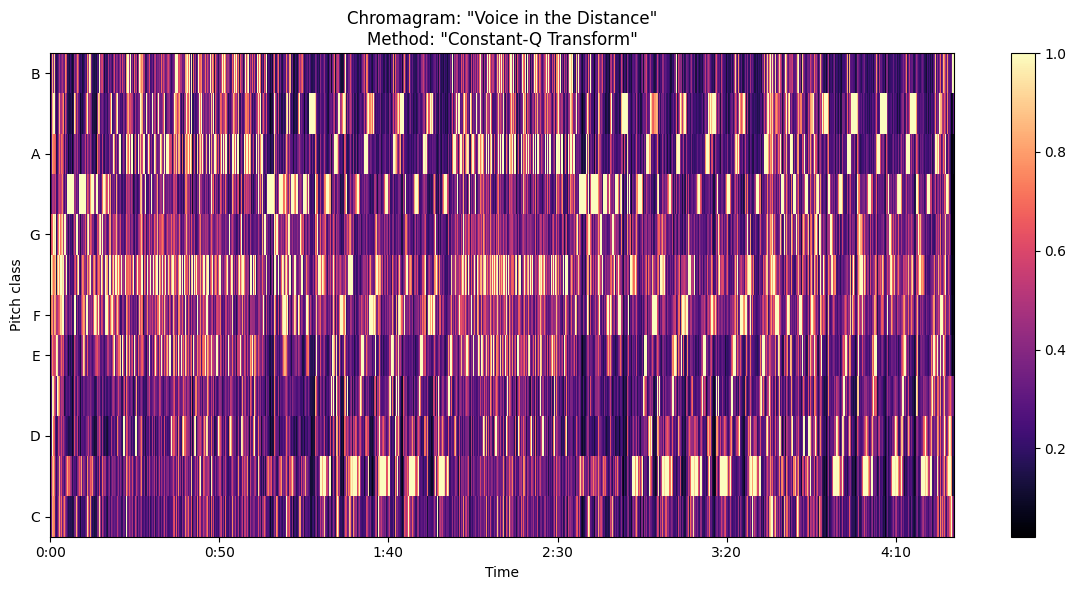

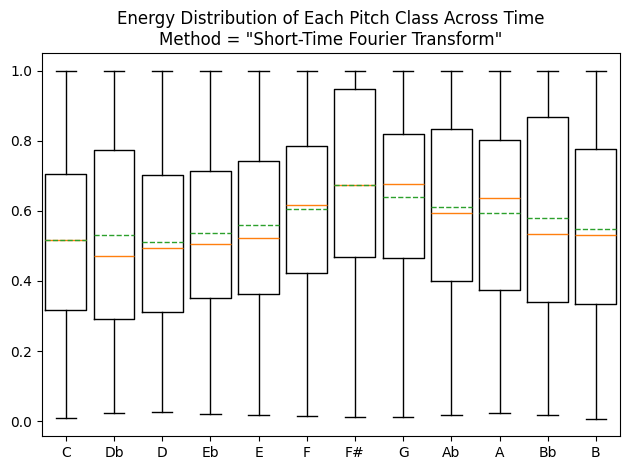

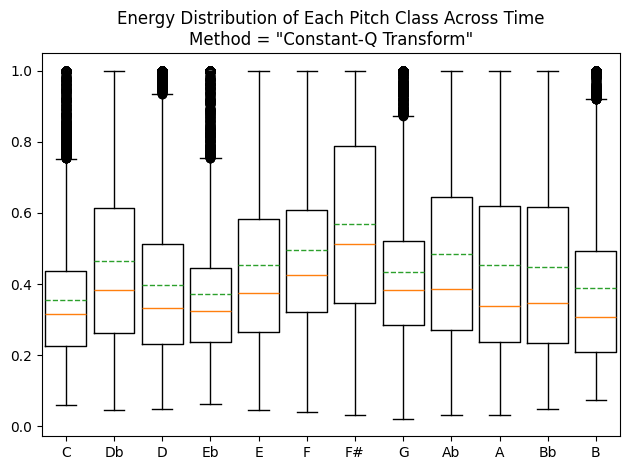

             track_title                          track_to_analyze_filename  \
0  Voice in the Distance  /home/emily/Downloads/Lady Napalm - Voice in t...   
1  Voice in the Distance  /home/emily/Downloads/Lady Napalm - Voice in t...   

                         method  hop_length  dissimilarity_index  \
0  Short-Time Fourier Transform        1024             0.036467   
1          Constant-Q Transform        1024             0.050624   

   chi2_goodness_of_fit_statistic  chi2_goodness_of_fit_p_value  \
0                       72.168800                  4.718936e-11   
1                      164.578916                  1.536186e-29   

   chi2_goodness_of_fit_cohens_w  kurtosis   entropy  
0                       2.452359 -0.788468  2.481349  
1                       3.703365 -0.210344  2.476785  


In [8]:
track_to_analyze = '/home/emily/Downloads/Lady Napalm - Voice in the Distance.mp3'
track_name = 'Voice in the Distance'
t_vd = KeyDetection(track_to_analyze, track_name)
t_vd.fit()
t_vd.summary_full()

In [9]:
t_vd.df

,track_title,track_to_analyze_filename,method,hop_length,key_as_chromatic_index,key_as_pitch_class,dissimilarity_index,chi2_goodness_of_fit_statistic,chi2_goodness_of_fit_p_value,chi2_goodness_of_fit_cohens_w,kurtosis,entropy
0,Voice in the Distance,/home/emily/Downloads/Lady Napalm - Voice in t...,Short-Time Fourier Transform,1024,6,F#,0.036467,72.168800,4.718936e-11,2.452359,-0.788468,2.481349
1,Voice in the Distance,/home/emily/Downloads/Lady Napalm - Voice in t...,Constant-Q Transform,1024,6,F#,0.050624,164.578916,1.536186e-29,3.703365,-0.210344,2.476785
